In [1]:
import csv 
import cv2
import numpy as np

In [2]:
def flip(img, measurement):
    return np.fliplr(img), -measurement

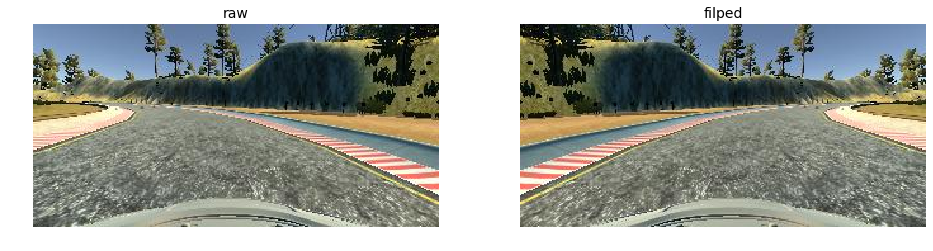

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 


img = cv2.imread('video/IMG/center_2018_12_21_22_08_59_913.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.axis('off')
plt.title('raw', size=14)
plt.imshow(img)
img_flip, mea = flip(img, 1)
plt.subplot(122)
plt.axis('off')
plt.title('filped', size=14)
plt.imshow(img_flip)
plt.show()

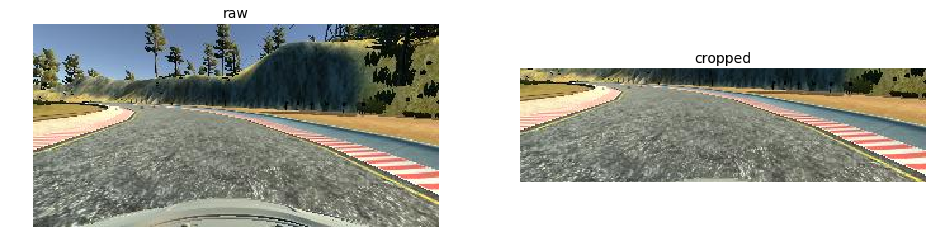

In [4]:
img_crop = img[50:140, :]
plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.axis('off')
plt.title('raw', size=14)
plt.imshow(img)
plt.subplot(122)
plt.axis('off')
plt.title('cropped', size=14)
plt.imshow(img_crop)
plt.show()

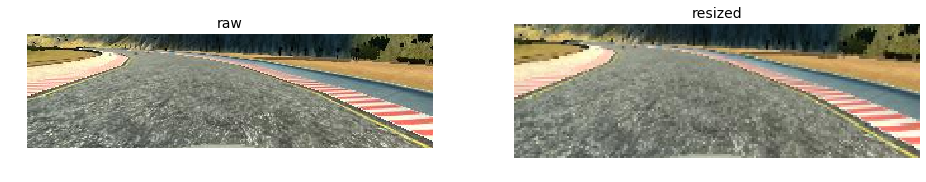

In [5]:
# I will use NVIDIA model and resize 66*200
img_resize = cv2.resize(img_crop, (200, 66))
plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.axis('off')
plt.title('raw', size=14)
plt.imshow(img_crop)
plt.subplot(122)
plt.axis('off')
plt.title('resized', size=14)
plt.imshow(img_resize)
plt.show()

In [3]:
def generator(samples, batch_size= 20):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(1):
                    name = './video/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    angle = float(batch_sample[3])*1.3
                    image_flip, angle_flip = flip(image, angle)  # flip
                    images.append(image)
                    images.append(image_flip)
                    angles.append(angle)
                    angles.append(angle_flip)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [4]:
import sklearn

samples = []
with open('video/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
samples = sklearn.utils.shuffle(samples)

length = len(samples)
train_length = int(length*0.8)

train_sample = samples
val_sample = samples[train_length:]

train_generator = generator(train_sample)
val_generator = generator(val_sample)

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, MaxPooling2D, Cropping2D, Dropout, SpatialDropout2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [6]:
def nvidia_model():
    def resize(img):
        import tensorflow as tf
        return tf.image.resize_images(img, (66, 200))
    
    model = Sequential()
    model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))
    # model.add(Lambda(resize))
    model.add(Lambda(lambda x: x/255.-0.5, ))  # normalization
    model.add(Conv2D(24, (5, 5), padding="same", strides=(2,2), activation="relu"))
    model.add(SpatialDropout2D(0.2))
    model.add(Conv2D(36, (5, 5), padding="same", strides=(2,2), activation="relu"))
    model.add(SpatialDropout2D(0.2))
    model.add(Conv2D(48, (5, 5), padding="valid", strides=(2,2), activation="relu"))
    model.add(SpatialDropout2D(0.2))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(SpatialDropout2D(0.2))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(SpatialDropout2D(0.2))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dropout(0.5))  
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.0001), loss='mse')
    
    return model

In [7]:
model = nvidia_model()

In [8]:
model.fit_generator(train_generator, 
                    steps_per_epoch= len(train_sample), 
                    validation_data=val_generator, 
                    validation_steps=len(val_sample),  
                    epochs=8) 
model.save('model.h5')

Epoch 1/8
1276/1276 [==============================] - 64s 50ms/step - loss: 0.0444 - val_loss: 0.0360
Epoch 2/8
1276/1276 [==============================] - 44s 35ms/step - loss: 0.0377 - val_loss: 0.0292
Epoch 3/8
1276/1276 [==============================] - 44s 35ms/step - loss: 0.0317 - val_loss: 0.0200
Epoch 4/8
1276/1276 [==============================] - 44s 35ms/step - loss: 0.0261 - val_loss: 0.0139
Epoch 5/8
1276/1276 [==============================] - 44s 35ms/step - loss: 0.0229 - val_loss: 0.0096
Epoch 6/8
1276/1276 [==============================] - 44s 35ms/step - loss: 0.0209 - val_loss: 0.0069
Epoch 7/8
1276/1276 [==============================] - 44s 35ms/step - loss: 0.0189 - val_loss: 0.0048
Epoch 8/8
1276/1276 [==============================] - 44s 35ms/step - loss: 0.0175 - val_loss: 0.0039
